# **Data Processing**

In this notebook, building on the findings from the data exploration phase, we prepare the dataset to be used by the agent to generate prompts for each patient.
The structure of this notebook is as follows:
1. Load the clinical_patient dataset
2. Extract treatment history for each patient using data_timeline_treatment.txt.
3. Extract mutation data from data_mutations.txt
4. Clean the data, including handling missing values and nulls
5. Add a cancer type column to provide high-level diagnostic context.
6. Combine metastatic site information into a single column, represented as a list of organs where tumor or metastatic involvement is present.
7. Add six additional columns from the clinical_data table to enrich the prompt context and support question generation.

In [1]:
!pip install pandas==2.3.0
!pip install seaborn==0.13.2
!pip install git+https://github.com/gaarangoa/samecode.git
!pip install scipy==1.15.3

  Cloning https://github.com/gaarangoa/samecode.git to /tmp/pip-req-build-ur8c2n1f
  Running command git clone --filter=blob:none --quiet https://github.com/gaarangoa/samecode.git /tmp/pip-req-build-ur8c2n1f
  Resolved https://github.com/gaarangoa/samecode.git to commit 7ad4025650514a971b18c27f1a61a4b049f09a90
  Preparing metadata (setup.py) ... done


### **Import Libraries**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from samecode.plot.pyplot import subplots
pd.set_option('display.max_columns', 1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Intern_summer2025/code/

/content/drive/MyDrive/Colab Notebooks/Intern_summer2025/code


## 1. Upload base dataset: clinical_patient.txt

In [4]:
data_patient = pd.read_csv('../data/msk_chord_2024/data_clinical_patient.txt', sep="\t", comment= "#")

In [5]:
data_patient.head()

,PATIENT_ID,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,HR,HER2
0,P-0000012,Female,White,Non-Spanish; Non-Hispanic,68.0,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,NaN,NaN,No,Unknown,118.454665,0:LIVING,No,No
1,P-0000015,Female,White,Non-Spanish; Non-Hispanic,45.0,Stage 1-3,1,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Unknown,NaN,NaN,NaN,Unknown,13.906834,1:DECEASED,Yes,No
2,P-0000036,Female,Other,Non-Spanish; Non-Hispanic,68.0,Stage 4,1,No,Yes,No,No,Yes,Yes,Yes,No,Yes,No,Never,NaN,NaN,NaN,Unknown,115.462887,0:LIVING,NaN,NaN
3,P-0000041,Female,White,Non-Spanish; Non-Hispanic,53.0,Stage 1-3,1,No,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Unknown,NaN,NaN,NaN,Prior medications to MSK,13.610944,1:DECEASED,No,No
4,P-0000066,Female,White,Non-Spanish; Non-Hispanic,71.0,Stage 1-3,1,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Never,NaN,NaN,NaN,Unknown,76.635532,0:LIVING,Yes,No


## 2. Extract treatment history

### Samples per patient

In [6]:
sample_data = pd.read_csv(
    '../data/msk_chord_2024/data_timeline_specimen_surgery.txt', sep='\t', skiprows=0
)

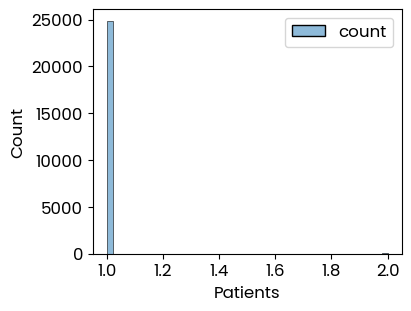

In [7]:
axs = subplots(rows=1, cols=1, h=3, w=4)
sns.histplot(
    sample_data.value_counts('PATIENT_ID').reset_index(), bins=50,
    ax=axs[0]
);

axs[0].set_xlabel('Patients');

**Fig 1**: Most of the patients have only 1 timepoint. Therefore, the pre and post for each treatment will be derived by looking at the collection time. If it is collected before the treatment is pre and if it is collected after the treatment is post. We don't have two molecular timepoints per patient.

In [8]:
treatment = pd.read_csv(
    '../data/msk_chord_2024/data_timeline_treatment.txt', sep='\t', skiprows=0
)

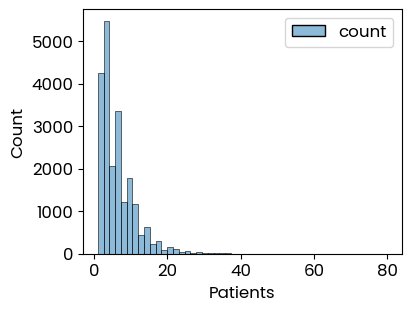

In [9]:
axs = subplots(rows=1, cols=1, h=3, w=4)
sns.histplot(
    treatment.value_counts('PATIENT_ID').reset_index(), bins=50,
    ax=axs[0]
)
axs[0].set_xlabel('Patients');

**Fig 2**: In average each patient had 6 treatments.

In [10]:
treatment.value_counts('PATIENT_ID').mean()

np.float64(6.284310529502165)

We consider only treatments after the initial event (positive values). The percentage of patient with two samples is less than 4%.

In [11]:
data = treatment.query('START_DATE >= 0').reset_index(drop=True)

In [12]:
data.value_counts('AGENT').reset_index().head(20)

,AGENT,count
0,INVESTIGATIONAL,5194
1,FLUOROURACIL,4356
2,LEUCOVORIN,3935
3,ZOLEDRONIC ACID,3775
4,IRINOTECAN,3573
5,CAPECITABINE,3363
6,CARBOPLATIN,3342
7,GEMCITABINE,3119
8,OXALIPLATIN,2999
9,BEVACIZUMAB,2430


In [13]:
def gf(x):
    agents = x.reset_index(drop=True).sort_values('START_DATE').AGENT.values
    unique_agents = list(agents)  # removes duplicates in order
    return ", ".join(unique_agents)

treatment_history = data.groupby('PATIENT_ID', group_keys=False).apply(gf).reset_index(name='TREATMENT_HISTORY')

/tmp/ipython-input-13-1415619573.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  treatment_history = data.groupby('PATIENT_ID', group_keys=False).apply(gf).reset_index(name='TREATMENT_HISTORY')


In [14]:
#To Save treatment history file
treatment_history.to_csv('../data/msk_chord_2024/treatment_history.csv', index=False)

In [15]:
#Get data related to treatments previosly processed
treatment_data = pd.read_csv('../data/msk_chord_2024/treatment_history.csv', sep=",", comment= "#")

In [16]:
treatment_data.head()

,PATIENT_ID,TREATMENT_HISTORY
0,P-0000012,"CISPLATIN, ETOPOSIDE, CARBOPLATIN, INVESTIGATI..."
1,P-0000015,"ZOLEDRONIC ACID, PACLITAXEL, CARBOPLATIN, GEMC..."
2,P-0000036,"CRIZOTINIB, CRIZOTINIB"
3,P-0000041,"PACLITAXEL PROTEIN-BOUND, ERIBULIN, INVESTIGAT..."
4,P-0000057,"FULVESTRANT, INVESTIGATIONAL, CAPECITABINE, IN..."


## 3. Extraction of molecular data.
Aggregation of mutations at the gene level. We extracted the mutated genes per patient as a string of genes separated by comma. Note that we are considering only truncated mutation (Those with funtional effect).

In [17]:
data = pd.read_csv('../data/msk_chord_2024/data_mutations.txt', sep='\t')

/tmp/ipython-input-17-109739556.py:1: DtypeWarning: Columns (44,49,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/msk_chord_2024/data_mutations.txt', sep='\t')


In [18]:
data['PATIENT_ID'] = [ "-".join(i.split('-')[:2]) for i in data.Tumor_Sample_Barcode]

In [19]:
data.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,t_ref_count,t_alt_count,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Exon_Number,COMMENTS,PATH_SCORE,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_Acid_Change,Amino_acids,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,Comments,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,FILTER,Feature,Feature_type,GENE_PHENO,GMAF,Gene,HGNC_ID,HGVS_OFFSET,HIGH_INF_POS,IMPACT,INTRON,IS_NEW,MA:FIS,MA:FImpact,MA:link.MSA,MA:link.PDB,MA:link.var,MA:protein.change,MINIMISED,MOTIF_NAME,MOTIF_POS,MOTIF_SCORE_CHANGE,PHENO,PICK,PUBMED,PolyPhen,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,TREMBL,TSL,Transcript,UNIPARC,VARIANT_CLASS,all_effects,amino_acid_change,cDNA_Change,cDNA_position,cdna_change,comments,n_depth,t_depth,transcript,PATIENT_ID
0,EGFR,1956,MSKCC,GRCh37,7,55242470,55242487,+,inframe_deletion,In_Frame_Del,DEL,TAAGAGAAGCAACATCTC,TAAGAGAAGCAACATCTC,-,rs121913438,NaN,P-0081657-T01-IM7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,319,288,281,0,ENST00000275493.2:c.2240_2257del,p.Leu747_Pro753delinsSer,p.L747_P753delinsS,ENST00000275493,NM_005228.3,747.0,tTAAGAGAAGCAACATCTCcg/tcg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P-0081657
1,PDGFRB,5159,MSKCC,GRCh37,5,149513271,149513271,+,missense_variant,Missense_Mutation,SNP,T,T,C,NaN,NaN,P-0081657-T01-IM7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,370,85,333,0,ENST00000261799.4:c.812A>G,p.His271Arg,p.H271R,ENST00000261799,NM_002609.3,271.0,cAc/cGc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P-0081657
2,RBM10,8241,MSKCC,GRCh37,X,47041565,47041598,+,frameshift_variant,Frame_Shift_Del,DEL,ACTACAATGCTCAGAGCCAGCAGTACCTGTACTG,ACTACAATGCTCAGAGCCAGCAGTACCTGTACTG,-,NaN,NaN,P-0081657-T01-IM7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,189,150,404,0,ENST00000329236.7:c.1556_1589del,p.Tyr519TrpfsTer96,p.Y519Wfs*96,ENST00000329236,NM_001204466.1,519.0,tACTACAATGCTCAGAGCCAGCAGTACCTGTACTGg/tg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P-0081657
3,TP53,7157,MSKCC,GRCh37,17,7578235,7578235,+,missense_variant,Missense_Mutation,SNP,T,T,C,rs1057520007,NaN,P-0083825-T01-IM7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,SOMATIC,NaN,NaN,NaN,MSK-IMPACT,NaN,NaN,187,111,789,0,ENST00000269305.4:c.614A>G,p.Tyr205Cys,p.Y205C,ENST00000269305,NM_001126112.2,205.0,tAt/tGt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [20]:
data.value_counts('Variant_Classification')

,count
Variant_Classification,
Missense_Mutation,142568
Frame_Shift_Del,23404
Nonsense_Mutation,20412
Frame_Shift_Ins,8902
Splice_Site,7436
In_Frame_Del,4004
In_Frame_Ins,899
5'Flank,417
Translation_Start_Site,279


In [21]:
data = data.query('Variant_Classification not in ["Silent", "Intron"]')

In [22]:
def gf(x):
    agents = x.Hugo_Symbol
    unique_agents = list(set(agents))  # removes duplicates in order
    return ", ".join(unique_agents)

data = data.groupby('PATIENT_ID', group_keys=False).apply(gf).reset_index(name='MUTATIONS')

/tmp/ipython-input-22-53319455.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('PATIENT_ID', group_keys=False).apply(gf).reset_index(name='MUTATIONS')


In [23]:
#To save mutations information
data.to_csv('../data/msk_chord_2024/mutations_list.csv', index=False)

In [24]:
#Get molecular data with mutations per patient
mutations_data = pd.read_csv('../data/msk_chord_2024/mutations_list.csv', sep=",", comment= "#")

In [25]:
mutations_data.head()

,PATIENT_ID,MUTATIONS
0,P-0000012,"PIK3C2G, FLT4, PIK3R3, BLM, MAP3K1, CCNE1, ATR..."
1,P-0000015,"ALK, ESR1, TP53, RNF43, CDK4, GATA3, PIK3CA"
2,P-0000036,"ERBB2, NOTCH4, IRS1, TP53, FBXW7, AR, TSHR"
3,P-0000041,"INPP4B, PIK3C2G, ERBB4, FLT4, NF2, NOTCH4, TP5..."
4,P-0000057,"NOTCH4, TP53, BARD1, PIK3CA, MAP3K13"


### Concatenate data (clinical_patient + treatments + mutations)

In [26]:
#Merge data_patient and treatment_data
patient_completed = data_patient.merge(treatment_data, on='PATIENT_ID', how='left')

#Merge data_patient and mutations_data
patient_completed = patient_completed.merge(mutations_data, on='PATIENT_ID', how='left')


In [27]:
patient_completed.head()

,PATIENT_ID,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,INTRA_ABDOMINAL,LIVER,LUNG,LYMPH_NODES,OTHER,PLEURA,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,HR,HER2,TREATMENT_HISTORY,MUTATIONS
0,P-0000012,Female,White,Non-Spanish; Non-Hispanic,68.0,Stage 1-3,2,No,No,No,Yes,No,Yes,Yes,Yes,No,No,Former/Current Smoker,NaN,NaN,No,Unknown,118.454665,0:LIVING,No,No,"CISPLATIN, ETOPOSIDE, CARBOPLATIN, INVESTIGATI...","PIK3C2G, FLT4, PIK3R3, BLM, MAP3K1, CCNE1, ATR..."
1,P-0000015,Female,White,Non-Spanish; Non-Hispanic,45.0,Stage 1-3,1,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Unknown,NaN,NaN,NaN,Unknown,13.906834,1:DECEASED,Yes,No,"ZOLEDRONIC ACID, PACLITAXEL, CARBOPLATIN, GEMC...","ALK, ESR1, TP53, RNF43, CDK4, GATA3, PIK3CA"
2,P-0000036,Female,Other,Non-Spanish; Non-Hispanic,68.0,Stage 4,1,No,Yes,No,No,Yes,Yes,Yes,No,Yes,No,Never,NaN,NaN,NaN,Unknown,115.462887,0:LIVING,NaN,NaN,"CRIZOTINIB, CRIZOTINIB","ERBB2, NOTCH4, IRS1, TP53, FBXW7, AR, TSHR"
3,P-0000041,Female,White,Non-Spanish; Non-Hispanic,53.0,Stage 1-3,1,No,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Unknown,NaN,NaN,NaN,Prior medications to MSK,13.610944,1:DECEASED,No,No,"PACLITAXEL PROTEIN-BOUND, ERIBULIN, INVESTIGAT...","INPP4B, PIK3C2G, ERBB4, FLT4, NF2, NOTCH4, TP5..."
4,P-0000066,Female,White,Non-Spanish; Non-Hispanic,71.0,Stage 1-3,1,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Never,NaN,NaN,NaN,Unknown,76.635532,0:LIVING,Yes,No,"INVESTIGATIONAL, FULVESTRANT, INVESTIGATIONAL,...","CD276, TP53, ESR1"


In [28]:
patient_completed.shape

(24950, 28)

## 4. Data cleaning
We removed records for patients with missing (NaN) values in two critical columns: 'CURRENT_AGE_DEID' and 'MUTATION'. These fields are essential for generating meaningful prompts and for downstream analysis.

For the remaining missing data, we applied the following imputation strategies to retain as much information as possible:

- **Treatment history**: For 7,666 patients with no treatment information, we assigned the value "Unknown" rather than dropping the records, allowing us to preserve their molecular data.

- **PD-L1 status**: For 17,046 patients with missing values in the "History of PD-L1" column, we filled in "Not available".

- **Gleason scores (first and highest reported)**: Since this information is primarily relevant for prostate cancer, we filled missing or null values with "Not available" to avoid misrepresenting the absence of data.

- **Hormone receptor markers (HR, HER2)**: These are relevant in cancers such as breast cancer. Missing values were replaced with "Not available" to preserve the patient entries.

After performing these cleaning steps, the number of patients was reduced from 24,950 to 23,777.

In [29]:
patient_completed.isnull().sum()

,0
PATIENT_ID,0
GENDER,0
RACE,0
ETHNICITY,0
CURRENT_AGE_DEID,3
STAGE_HIGHEST_RECORDED,0
NUM_ICDO_DX,0
ADRENAL_GLANDS,0
BONE,0
CNS_BRAIN,0


In [30]:
patient_completed_cleaned = patient_completed.dropna(subset=['CURRENT_AGE_DEID','MUTATIONS']).copy()

In [31]:
patient_completed_cleaned['PATIENT_ID'].nunique()

23777

In [32]:
patient_completed_cleaned.shape

(23777, 28)

In [33]:
patient_completed_cleaned.isnull().sum()

,0
PATIENT_ID,0
GENDER,0
RACE,0
ETHNICITY,0
CURRENT_AGE_DEID,0
STAGE_HIGHEST_RECORDED,0
NUM_ICDO_DX,0
ADRENAL_GLANDS,0
BONE,0
CNS_BRAIN,0


In [34]:
# Dictionary with default values for columns with missing values
fill_values = {
    'TREATMENT_HISTORY': 'Unknown',
    'GLEASON_FIRST_REPORTED': 'Not available',
    'GLEASON_HIGHEST_REPORTED': 'Not available',
    'HR': 'Not available',
    'HER2': 'Not available',
    'HISTORY_OF_PDL1': 'Not available'
}

# Replace "null" and None with pd.NA in the GLEASON_FIRST_REPORTED column
patient_completed_cleaned['GLEASON_FIRST_REPORTED'].replace(["null", None], pd.NA, inplace=True)

# Apply fillna to all specified columns at once
patient_completed_cleaned.fillna(value=fill_values, inplace=True)


/tmp/ipython-input-34-712239758.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  patient_completed_cleaned['GLEASON_FIRST_REPORTED'].replace(["null", None], pd.NA, inplace=True)


In [35]:
patient_completed_cleaned.isnull().sum()

,0
PATIENT_ID,0
GENDER,0
RACE,0
ETHNICITY,0
CURRENT_AGE_DEID,0
STAGE_HIGHEST_RECORDED,0
NUM_ICDO_DX,0
ADRENAL_GLANDS,0
BONE,0
CNS_BRAIN,0


In [36]:
patient_completed_cleaned['PATIENT_ID'].nunique()

23777

In [37]:
patient_completed_cleaned.shape

(23777, 28)

## 5. Cancer type information
Using the clinical_data table, we extract the 'Patient ID' and 'Cancer Type' columns to retrieve diagnostic information. We then rename 'Patient ID' to 'PATIENT_ID' to match the format in our dataset. To avoid inconsistencies caused by patients linked to multiple cancer types, we drop duplicate entries and retain only one cancer type per patient. Finally, we merge this information into our main dataset by matching on 'PATIENT_ID', adding a new column named 'Cancer Type'.

In [38]:
clinical_data = pd.read_csv('../data/msk_chord_2024/msk_chord_2024_clinical_data.tsv', sep="\t", comment= "#")

In [39]:
cancer_info = clinical_data[['Patient ID', 'Cancer Type']].copy()
cancer_info.rename(columns={'Patient ID': 'PATIENT_ID'}, inplace=True)

cancer_info["PATIENT_ID"].nunique()

24950

We dropped rows with patients than have more than one cancer type for possible misslabeled

In [40]:
cancer_info_unique = cancer_info.drop_duplicates(subset='PATIENT_ID')
cancer_info_unique.head()

,PATIENT_ID,Cancer Type
0,P-0000012,Breast Cancer
2,P-0000015,Breast Cancer
3,P-0000036,Non-Small Cell Lung Cancer
4,P-0000041,Breast Cancer
5,P-0000057,Breast Cancer


We merge Cancer Type info to patient_completed_cleaned

In [41]:
patient_completed_cleaned = patient_completed_cleaned.merge(cancer_info_unique, on='PATIENT_ID', how='left')
patient_completed_cleaned['PATIENT_ID'].nunique()

23777

In [42]:
patient_completed_cleaned["PATIENT_ID"].duplicated().sum()

np.int64(0)

In [43]:
#Save file patient_completed_cleaned
patient_completed_cleaned.to_csv('../data/msk_chord_2024/patient_completed_cleaned.csv', index=False)

## 6. Combine metastatic site information into a single column

We begin by dropping the column "OTHER" from patient_completed_cleaned, as it does not provide information about a specific organ affected by metastasis and is therefore not useful for prompt generation.

Next, we create a new column named 'METASTATIC_SITES' for each patient. This column aggregates information from nine organ-specific columns: 'ADRENAL_GLANDS', 'BONE', 'CNS_BRAIN', 'INTRA_ABDOMINAL', 'LIVER', 'LUNG', 'LYMPH_NODES', 'PLEURA', and 'REPRODUCTIVE_ORGANS'.
If a patient has a "Yes" value in any of these columns, the corresponding organ name (formatted for readability, e.g., 'CNS_BRAIN' becomes 'Cns Brain') is added to a comma-separated list. If none of the columns indicate metastasis, the value is set to "Unknown".

This transformation allows us to represent metastatic involvement in a compact, human-readable format that can be easily incorporated into prompt generation and downstream tasks.

In [47]:
patient_completed_cleaned = pd.read_csv('../data/msk_chord_2024/patient_completed_cleaned.csv', sep=",", comment= "#")

In [48]:
patient_completed_cleaned.shape

(23777, 29)

In [49]:
#Drop column "OTHER" because it does not contain the information about the specific organ with metastasis.
patient_completed_cleaned.drop(columns=['OTHER'], inplace=True)

# List of metastasis-related organ columns (standardized to match actual column names)
metastatic_columns = ['ADRENAL_GLANDS', 'BONE', 'CNS_BRAIN', 'INTRA_ABDOMINAL',
                      'LIVER', 'LUNG', 'LYMPH_NODES', 'PLEURA', 'REPRODUCTIVE_ORGANS']

# Function to collect organs with metastasis
def get_metastatic_sites(row):
    return ', '.join([organ.replace('_', ' ').title() for organ in metastatic_columns if row[organ].strip().lower() == 'yes']) or 'Unknown'

# Apply the function to create a new column
patient_completed_cleaned['METASTATIC_SITES'] = patient_completed_cleaned.apply(get_metastatic_sites, axis=1)

In [50]:
data_prompts = patient_completed_cleaned.drop(columns=metastatic_columns)
data_prompts.head()

,PATIENT_ID,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,HR,HER2,TREATMENT_HISTORY,MUTATIONS,Cancer Type,METASTATIC_SITES
0,P-0000012,Female,White,Non-Spanish; Non-Hispanic,68.0,Stage 1-3,2,Former/Current Smoker,Not available,Not available,No,Unknown,118.454665,0:LIVING,No,No,"CISPLATIN, ETOPOSIDE, CARBOPLATIN, INVESTIGATI...","PIK3C2G, FLT4, PIK3R3, BLM, MAP3K1, CCNE1, ATR...",Breast Cancer,"Intra Abdominal, Lung, Lymph Nodes"
1,P-0000015,Female,White,Non-Spanish; Non-Hispanic,45.0,Stage 1-3,1,Unknown,Not available,Not available,Not available,Unknown,13.906834,1:DECEASED,Yes,No,"ZOLEDRONIC ACID, PACLITAXEL, CARBOPLATIN, GEMC...","ALK, ESR1, TP53, RNF43, CDK4, GATA3, PIK3CA",Breast Cancer,"Bone, Cns Brain, Liver, Lung, Lymph Nodes, Pleura"
2,P-0000036,Female,Other,Non-Spanish; Non-Hispanic,68.0,Stage 4,1,Never,Not available,Not available,Not available,Unknown,115.462887,0:LIVING,Not available,Not available,"CRIZOTINIB, CRIZOTINIB","ERBB2, NOTCH4, IRS1, TP53, FBXW7, AR, TSHR",Non-Small Cell Lung Cancer,"Bone, Liver, Lung, Lymph Nodes, Pleura"
3,P-0000041,Female,White,Non-Spanish; Non-Hispanic,53.0,Stage 1-3,1,Unknown,Not available,Not available,Not available,Prior medications to MSK,13.610944,1:DECEASED,No,No,"PACLITAXEL PROTEIN-BOUND, ERIBULIN, INVESTIGAT...","INPP4B, PIK3C2G, ERBB4, FLT4, NF2, NOTCH4, TP5...",Breast Cancer,"Bone, Cns Brain, Liver, Pleura"
4,P-0000066,Female,White,Non-Spanish; Non-Hispanic,71.0,Stage 1-3,1,Never,Not available,Not available,Not available,Unknown,76.635532,0:LIVING,Yes,No,"INVESTIGATIONAL, FULVESTRANT, INVESTIGATIONAL,...","CD276, TP53, ESR1",Breast Cancer,"Bone, Liver, Lung, Lymph Nodes, Pleura, Reprod..."


In [51]:
data_prompts.shape

(23777, 20)

In [52]:
data_prompts[['PATIENT_ID','METASTATIC_SITES']]

,PATIENT_ID,METASTATIC_SITES
0,P-0000012,"Intra Abdominal, Lung, Lymph Nodes"
1,P-0000015,"Bone, Cns Brain, Liver, Lung, Lymph Nodes, Pleura"
2,P-0000036,"Bone, Liver, Lung, Lymph Nodes, Pleura"
3,P-0000041,"Bone, Cns Brain, Liver, Pleura"
4,P-0000066,"Bone, Liver, Lung, Lymph Nodes, Pleura, Reprod..."
...,...,...
23772,P-0087885,"Bone, Lung, Lymph Nodes"
23773,P-0089690,Bone
23774,P-0089687,Unknown
23775,P-0089676,Unknown


In [53]:
data_prompts = data_prompts.rename(columns={'Cancer Type': 'CANCER_TYPE'})

In [54]:
data_prompts.to_csv('../data/msk_chord_2024/data_prompts.csv', index=False)

In [55]:
data_prompts.head()

,PATIENT_ID,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,HR,HER2,TREATMENT_HISTORY,MUTATIONS,CANCER_TYPE,METASTATIC_SITES
0,P-0000012,Female,White,Non-Spanish; Non-Hispanic,68.0,Stage 1-3,2,Former/Current Smoker,Not available,Not available,No,Unknown,118.454665,0:LIVING,No,No,"CISPLATIN, ETOPOSIDE, CARBOPLATIN, INVESTIGATI...","PIK3C2G, FLT4, PIK3R3, BLM, MAP3K1, CCNE1, ATR...",Breast Cancer,"Intra Abdominal, Lung, Lymph Nodes"
1,P-0000015,Female,White,Non-Spanish; Non-Hispanic,45.0,Stage 1-3,1,Unknown,Not available,Not available,Not available,Unknown,13.906834,1:DECEASED,Yes,No,"ZOLEDRONIC ACID, PACLITAXEL, CARBOPLATIN, GEMC...","ALK, ESR1, TP53, RNF43, CDK4, GATA3, PIK3CA",Breast Cancer,"Bone, Cns Brain, Liver, Lung, Lymph Nodes, Pleura"
2,P-0000036,Female,Other,Non-Spanish; Non-Hispanic,68.0,Stage 4,1,Never,Not available,Not available,Not available,Unknown,115.462887,0:LIVING,Not available,Not available,"CRIZOTINIB, CRIZOTINIB","ERBB2, NOTCH4, IRS1, TP53, FBXW7, AR, TSHR",Non-Small Cell Lung Cancer,"Bone, Liver, Lung, Lymph Nodes, Pleura"
3,P-0000041,Female,White,Non-Spanish; Non-Hispanic,53.0,Stage 1-3,1,Unknown,Not available,Not available,Not available,Prior medications to MSK,13.610944,1:DECEASED,No,No,"PACLITAXEL PROTEIN-BOUND, ERIBULIN, INVESTIGAT...","INPP4B, PIK3C2G, ERBB4, FLT4, NF2, NOTCH4, TP5...",Breast Cancer,"Bone, Cns Brain, Liver, Pleura"
4,P-0000066,Female,White,Non-Spanish; Non-Hispanic,71.0,Stage 1-3,1,Never,Not available,Not available,Not available,Unknown,76.635532,0:LIVING,Yes,No,"INVESTIGATIONAL, FULVESTRANT, INVESTIGATIONAL,...","CD276, TP53, ESR1",Breast Cancer,"Bone, Liver, Lung, Lymph Nodes, Pleura, Reprod..."


## 7. Add additional columns
We added six additional columns from the clinical_data table to enrich the prompt context and support question generation. These variables were selected based on their relevance to tumor biology and potential impact on treatment response.

For context:

Fraction_Genome_Altered: Proportion of the genome affected by copy number alterations.

MSI_Type: Microsatellite instability status, which reflects DNA mismatch repair deficiency.

Mutation_Count: Total number of detected somatic mutations.

Tumor_Purity: Estimated proportion of tumor cells in the sample.

For question generation:

Primary_Tumor_Site: Anatomical location of the primary tumor.

TMB_nonsynonymous: Tumor mutational burden based on nonsynonymous mutations, often linked to immunotherapy response.

These additions enhance both the informativeness of the prompt and the ability to generate targeted clinical questions.

In [58]:
data_prompts.shape

(23777, 20)

In [57]:
data_prompts = pd.read_csv('../data/msk_chord_2024/data_prompts.csv', sep=",", comment= "#")

In [59]:
cancer_info2add = clinical_data[['Patient ID','Fraction Genome Altered', 'MSI Type','Mutation Count',
                          'Primary Tumor Site', 'TMB (nonsynonymous)', 'Tumor Purity']].copy()


cancer_info2add.rename(columns={
    'Patient ID': 'PATIENT_ID',
    'Fraction Genome Altered': 'Fraction_Genome_Altered',
    'MSI Type': 'MSI_Type',
    'Mutation Count': 'Mutation_Count',
    'Primary Tumor Site': 'Primary_Tumor_Site',
    'TMB (nonsynonymous)': 'TMB_nonsynonymous',
    'Tumor Purity': 'Tumor_Purity'
    }, inplace=True)


In [62]:
cancer_info2add.drop_duplicates(subset='PATIENT_ID', inplace=True)

In [63]:
cancer_info2add.shape

(24950, 7)

In [64]:
data_prompts = data_prompts.merge(cancer_info2add, on='PATIENT_ID', how='left')


In [65]:
data_prompts.isnull().sum()

,0
PATIENT_ID,0
GENDER,0
RACE,0
ETHNICITY,0
CURRENT_AGE_DEID,0
STAGE_HIGHEST_RECORDED,0
NUM_ICDO_DX,0
SMOKING_PREDICTIONS_3_CLASSES,0
GLEASON_FIRST_REPORTED,0
GLEASON_HIGHEST_REPORTED,0


In [66]:
data_prompts.shape

(23777, 26)

In [67]:
#To save data for prompts
data_prompts.to_csv('../data/msk_chord_2024/data_prompts.csv', index=False)